 ## **Importing Modules and Libraries**

In [280]:
# importing required libraries
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import pickle
from os import path
import os
import json

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from sklearn import metrics
from sklearn import preprocessing

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

 ### Cek ketersediaan GPU

In [303]:
print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 3050 Laptop GPU


 ## **Importing Datasets**

In [304]:
# Load dataset UNSW-NB15 dan CTU-13
unsw_data = pd.read_csv('./Dataset/UNSW_NB15_training-set.csv')
ctu_attack = pd.read_csv('./Dataset/CTU13_Attack_Traffic.csv')
ctu_normal = pd.read_csv('./Dataset/CTU13_Normal_Traffic.csv')

# Ubah semua kolom ke huruf kecil untuk konsistensi
ctu_attack.columns = ctu_attack.columns.str.lower()
ctu_normal.columns = ctu_normal.columns.str.lower()

# Tambahkan label untuk data CTU-13
ctu_attack['label'] = 'ransomware'
ctu_normal['label'] = 'normal'

# Mapping label 0 dan 1 pada UNSW-NB15 ke 'normal' dan 'ransomware'
unsw_data['label'] = unsw_data['label'].map({0: 'normal', 1: 'ransomware'})

# Gabungkan data CTU-13
ctu_data = pd.concat([ctu_attack, ctu_normal], ignore_index=True)


# Gabungkan dataset UNSW-NB15 dan CTU-13
data = pd.concat([unsw_data, ctu_data], ignore_index=True)

In [305]:
data.head(n=5)

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,init bwd win byts,fwd act data pkts,active mean,active std,active max,active min,idle mean,idle std,idle max,idle min
0,1.0,0.121478,tcp,-,FIN,6.0,4.0,258.0,172.0,74.087490,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,0.649902,tcp,-,FIN,14.0,38.0,734.0,42014.0,78.473372,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,1.623129,tcp,-,FIN,8.0,16.0,364.0,13186.0,14.170161,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,1.681642,tcp,ftp,FIN,12.0,12.0,628.0,770.0,13.677108,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,0.449454,tcp,-,FIN,10.0,6.0,534.0,268.0,33.373826,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [306]:
# Dimensions of the datasets
print("(rows, columns):", data.shape)

(rows, columns): (267553, 103)


#### Drop '-' pada kolom service

In [307]:
if 'service' in data.columns:
    print("\nService Distribution in Training Data:")
    print(data['service'].value_counts())


Service Distribution in Training Data:
service
-           94168
dns         47294
http        18724
smtp         5058
ftp-data     3995
ftp          3428
ssh          1302
pop3         1105
dhcp           94
snmp           80
ssl            56
irc            25
radius         12
Name: count, dtype: int64


In [308]:
# Menghapus nilai "-" dari data
data = data[data['service'] != '-']

In [309]:
# Dimensions of the datasets after drop '-' in service column
print("(rows, columns):", data.shape)

(rows, columns): (173385, 103)


 ## **Data Visualization**

Class distribution: ransomware vs normal:
label
ransomware    100583
normal         72802
Name: count, dtype: int64


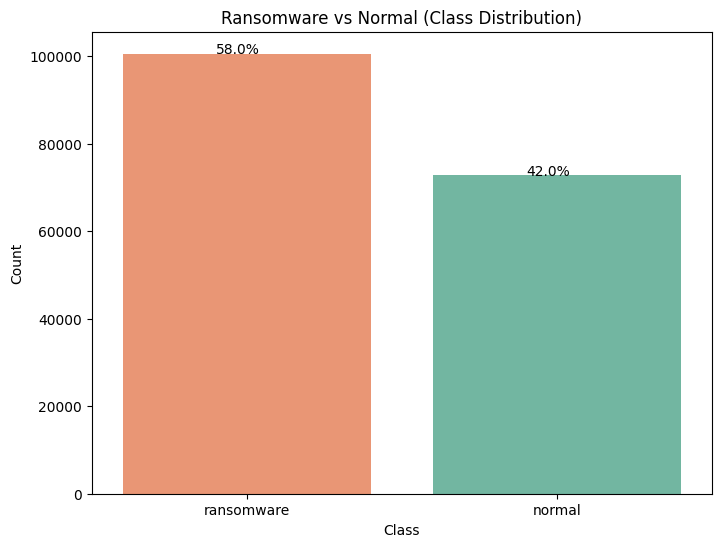

In [310]:
if 'label' in data.columns:
    print("Class distribution: ransomware vs normal:")
    class_counts = data['label'].value_counts()
    print(class_counts)

    # Plot the distribution of classes
    plt.figure(figsize=(8, 6))

    ax = sns.countplot(data=data, x='label', hue='label', order=class_counts.index, palette='Set2', legend=False)
    plt.xticks(rotation=0)
    plt.title('Ransomware vs Normal (Class Distribution)')
    plt.xlabel('Class')
    plt.ylabel('Count')

    # Add percentages on top of the bars
    total = len(data)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2 - 0.1
        y = p.get_height() + 5
        ax.annotate(percentage, (x, y))

    # Save the figure
    plt.savefig('./Visualisasi/label_bar_chart.png')

    # Show the figure
    plt.show()

 ## **Data Preprocessing**

In [311]:
# Hapus kolom id
data = data.drop(columns=['id'])

# Identifikasi fitur numerik
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Lakukan normalisasi dengan MinMaxScaler
scaler = MinMaxScaler()
data[numeric_features] = scaler.fit_transform(data[numeric_features])

In [312]:
# Data Preprocessing
label_encoder = LabelEncoder()
for column in ['proto', 'service', 'state', 'attack_cat']:
    data[column] = label_encoder.fit_transform(data[column])

 ## **Label Encoding**

In [313]:
# Inisialisasi encoder
le = LabelEncoder()

# Fit dan transformasi label
data['label'] = le.fit_transform(data['label'])

data.fillna(0, inplace=True)

 ## **Data Splitting**

In [314]:
# Define features and target variable
X_train = data.drop('label', axis=1).values
y_train = data['label'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Kami menggunakan Data Training = 80% dan Data Testing = 20%, dengan random state 42

In [315]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Gunakan CUDA GPU untuk model

In [316]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [317]:
# Convert the dataset to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32) 
y_train_tensor = torch.tensor(y_train, dtype=torch.long)     
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)    
y_test_tensor = torch.tensor(y_test, dtype=torch.long) 

 ## **Classification without Tuning**

#### Karena data cukup besar dan kompleks, maka kami menggunakan Fold 5, Epoch 4 dan default hyperparameters: num_heads=8, embed_dim=256, dropout=0.1, lr=0.001, batch_size=32

Using default hyperparameters: nhead=8, d_model=256, dropout=0.1, lr=0.001, batch_size=32
Fold 1/5
Epoch 1/4: Training Loss: 0.2517, Validation Loss: 0.3118, Accuracy: 86.69%, F1 Score: 0.8647
Saved best model for fold 1 at epoch 1.
Epoch 2/4: Training Loss: 0.2946, Validation Loss: 0.2727, Accuracy: 89.62%, F1 Score: 0.8961
Saved best model for fold 1 at epoch 2.
Epoch 3/4: Training Loss: 0.3293, Validation Loss: 0.3029, Accuracy: 88.33%, F1 Score: 0.8841
Epoch 4/4: Training Loss: 0.4409, Validation Loss: 0.3877, Accuracy: 86.02%, F1 Score: 0.8561
Fold 2/5
Epoch 1/4: Training Loss: 0.3268, Validation Loss: 0.4603, Accuracy: 76.77%, F1 Score: 0.7652
Saved best model for fold 2 at epoch 1.
Epoch 2/4: Training Loss: 0.4584, Validation Loss: 0.4600, Accuracy: 77.18%, F1 Score: 0.7696
Saved best model for fold 2 at epoch 2.
Epoch 3/4: Training Loss: 0.4503, Validation Loss: 0.4640, Accuracy: 76.52%, F1 Score: 0.7628
Epoch 4/4: Training Loss: 0.4677, Validation Loss: 0.4910, Accuracy: 76.26

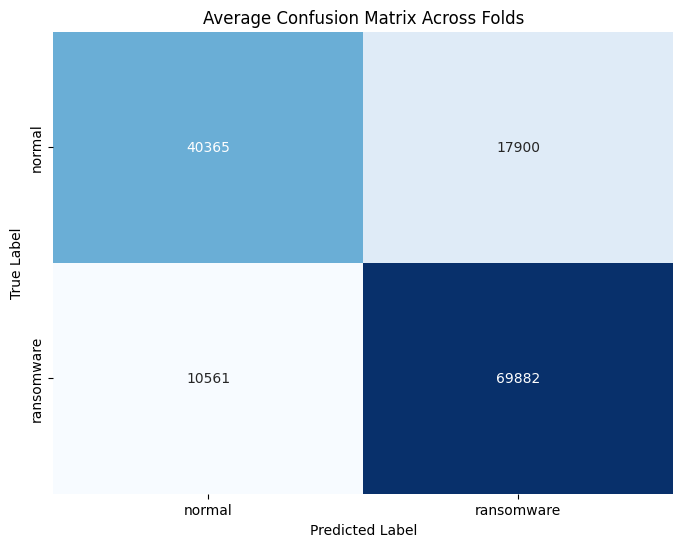


Classification Report for All Folds:
              precision    recall  f1-score   support

      normal       0.79      0.69      0.74     58265
  ransomware       0.80      0.87      0.83     80443

    accuracy                           0.79    138708
   macro avg       0.79      0.78      0.79    138708
weighted avg       0.79      0.79      0.79    138708



In [296]:
class_names = le.classes_

# Define TransformerModel class
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, nhead, d_model, dropout):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.dropout = nn.Dropout(dropout)
        self.output_layer = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        x = self.dropout(x)
        return self.output_layer(x)

# K-Fold dan Epoch
k_folds = 5
num_epochs = 4

# Hyperparameters
input_dim = X_train_tensor.shape[1]
num_classes = len(class_names)
nhead = 8
d_model = 256
dropout = 0.1
lr = 1e-3
batch_size = 32

model_dir = './Model/Default'
os.makedirs(model_dir, exist_ok=True)

# K-Fold Cross-Validation
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Metrics collection
all_labels = []
all_preds = []
fold_results = []

print(f"Using default hyperparameters: nhead={nhead}, d_model={d_model}, "
      f"dropout={dropout}, lr={lr}, batch_size={batch_size}")

for fold, (train_index, val_index) in enumerate(kf.split(X_train_tensor)):
    print(f"Fold {fold + 1}/{k_folds}")

    # Data Loaders
    train_dataset = TensorDataset(X_train_tensor[train_index], y_train_tensor[train_index])
    val_dataset = TensorDataset(X_train_tensor[val_index], y_train_tensor[val_index])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    # Model, loss, and optimizer
    model = TransformerModel(input_dim=input_dim, num_classes=num_classes, nhead=nhead, d_model=d_model, dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    best_metrics = None

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        
        # Validation loop
        model.eval()
        total_val_loss = 0
        fold_labels, fold_preds = [], []

        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                val_outputs = model(X_val_batch)
                val_loss = criterion(val_outputs, y_val_batch)
                total_val_loss += val_loss.item()

                _, preds = torch.max(val_outputs, 1)
                fold_labels.extend(y_val_batch.cpu().numpy())
                fold_preds.extend(preds.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        accuracy = accuracy_score(fold_labels, fold_preds) * 100
        f1 = f1_score(fold_labels, fold_preds, average='weighted')

        print(f"Epoch {epoch + 1}/{num_epochs}: Training Loss: {avg_train_loss:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%, F1 Score: {f1:.4f}")

        # Save the best model for this fold
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_metrics = (avg_train_loss, avg_val_loss, accuracy, f1)
            model_path = os.path.join(model_dir, f"best_model_fold_{fold + 1}.pth")
            torch.save(model.state_dict(), model_path)
            print(f"Saved best model for fold {fold + 1} at epoch {epoch + 1}.")

    fold_results.append(best_metrics)
    all_labels.extend(fold_labels)
    all_preds.extend(fold_preds)

# Display K-Fold Results
print(f"\nK-Fold Cross-Validation Results:")
for i, result in enumerate(fold_results):
    print(f"Fold {i + 1} - Training Loss: {result[0]:.4f}, Validation Loss: {result[1]:.4f}, "
          f"Accuracy: {result[2]:.2f}%, F1 Score: {result[3]:.4f}")

# Average Metrics across folds
avg_train_loss = np.mean([result[0] for result in fold_results])
avg_val_loss = np.mean([result[1] for result in fold_results])
avg_accuracy = np.mean([result[2] for result in fold_results])
avg_f1 = np.mean([result[3] for result in fold_results])

print('-----------------------------------------------------------------------------------------')
print("\nAverage Metrics:")
print(f"Average Training Loss: {avg_train_loss:.4f}")
print(f"Average Validation Loss: {avg_val_loss:.4f}")
print(f"Average Accuracy: {avg_accuracy:.2f}%")
print(f"Average F1 Score: {avg_f1:.4f}")

# Confusion Matrix
average_conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(average_conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Average Confusion Matrix Across Folds')
plt.show()

# Classification Report
print("\nClassification Report for All Folds:")
print(classification_report(all_labels, all_preds, target_names=class_names))

Sebelum Tuning Hyperparameter, di dapatkan rata-rata Training Loss: 0.4234, Validation Loss: 0.3988, Accuracy: 81.03% dan F1 Score: 0.7791

## **Find the best Tuning**

#### Kemudian menggunakan ParameterGrid untuk mencari Parameter terbaik

In [318]:
from sklearn.model_selection import ParameterGrid

class_names = le.classes_

# Transformer Model Definition
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, nhead, d_model, dropout):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.dropout = nn.Dropout(dropout)
        self.output_layer = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        x = self.dropout(x)
        return self.output_layer(x)

# Hyperparameter grid
param_grid = {
    'nhead': [4, 8, 16],
    'd_model': [128, 256, 512],
    'dropout': [0.1],
    'lr': [1e-3],
    'batch_size': [32]
}

# Fixed hyperparameters
input_dim = X_train_tensor.shape[1]
num_classes = len(class_names)
num_epochs = 4
k_folds = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_avg_val_loss = float('inf')
best_params = None
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Hyperparameter Tuning Loop
for params in ParameterGrid(param_grid):
    print(f"Evaluating params: {params}")
    
    fold_results = []
    for fold, (train_index, val_index) in enumerate(kf.split(X_train_tensor)):
        print(f"Fold {fold + 1}/{k_folds}")

        # Data loaders for the current fold
        train_dataset = TensorDataset(X_train_tensor[train_index], y_train_tensor[train_index])
        val_dataset = TensorDataset(X_train_tensor[val_index], y_train_tensor[val_index])
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

        # Model, criterion, optimizer initialization
        model = TransformerModel(input_dim=input_dim, num_classes=num_classes,
                                 nhead=params['nhead'], d_model=params['d_model'], dropout=params['dropout']).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])

        best_val_loss = float('inf')
        best_metrics = None

        # Training & Validation Loop
        for epoch in range(num_epochs):
            model.train()
            total_train_loss = 0

            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()

            avg_train_loss = total_train_loss / len(train_loader)
            
            # Validation phase
            model.eval()
            total_val_loss = 0
            all_preds, all_labels = [], []

            with torch.no_grad():
                for X_val_batch, y_val_batch in val_loader:
                    X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                    val_outputs = model(X_val_batch)
                    val_loss = criterion(val_outputs, y_val_batch)
                    total_val_loss += val_loss.item()

                    _, preds = torch.max(val_outputs, 1)
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(y_val_batch.cpu().numpy())

            avg_val_loss = total_val_loss / len(val_loader)
            accuracy = accuracy_score(all_labels, all_preds) * 100
            f1 = f1_score(all_labels, all_preds, average='weighted')

            print(f"Epoch {epoch + 1}/{num_epochs}: Training Loss: {avg_train_loss:.4f}, "
                  f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%, F1 Score: {f1:.4f}")

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_metrics = (avg_train_loss, avg_val_loss, accuracy, f1)

        fold_results.append(best_metrics)

    # Compute average metrics across folds
    avg_train_loss = np.mean([result[0] for result in fold_results])
    avg_val_loss = np.mean([result[1] for result in fold_results])
    avg_accuracy = np.mean([result[2] for result in fold_results])
    avg_f1 = np.mean([result[3] for result in fold_results])

    print(f"\nK-Fold Cross-Validation Results:")
    print(f"Avg Training Loss: {avg_train_loss:.4f}, Avg Validation Loss: {avg_val_loss:.4f}, "
          f"Avg Accuracy: {avg_accuracy:.2f}%, Avg F1 Score: {avg_f1:.4f}")
    print('--------------------------------------------------------------------------------------------------')

    if avg_val_loss < best_avg_val_loss:
        best_avg_val_loss = avg_val_loss
        best_params = params

print(f"\nBest Hyperparameters:")
print(f"Parameters: {best_params}")
print(f"Best Average Validation Loss: {best_avg_val_loss:.4f}")

Evaluating params: {'batch_size': 32, 'd_model': 128, 'dropout': 0.1, 'lr': 0.001, 'nhead': 4}
Fold 1/5
Epoch 1/4: Training Loss: 0.1236, Validation Loss: 0.0814, Accuracy: 97.17%, F1 Score: 0.9717
Epoch 2/4: Training Loss: 0.0824, Validation Loss: 0.0645, Accuracy: 97.64%, F1 Score: 0.9764
Epoch 3/4: Training Loss: 0.0701, Validation Loss: 0.0534, Accuracy: 97.94%, F1 Score: 0.9794
Epoch 4/4: Training Loss: 0.0626, Validation Loss: 0.0607, Accuracy: 97.49%, F1 Score: 0.9749
Fold 2/5
Epoch 1/4: Training Loss: 0.1310, Validation Loss: 0.0819, Accuracy: 96.91%, F1 Score: 0.9691
Epoch 2/4: Training Loss: 0.0824, Validation Loss: 0.0965, Accuracy: 96.47%, F1 Score: 0.9648
Epoch 3/4: Training Loss: 0.0718, Validation Loss: 0.0571, Accuracy: 97.94%, F1 Score: 0.9794
Epoch 4/4: Training Loss: 0.0636, Validation Loss: 0.0789, Accuracy: 97.18%, F1 Score: 0.9719
Fold 3/5
Epoch 1/4: Training Loss: 0.1223, Validation Loss: 0.0848, Accuracy: 97.18%, F1 Score: 0.9718
Epoch 2/4: Training Loss: 0.0853

### Simpan Hyperparameters Terbaik

In [319]:
# Save best hyperparameters to a text file
output_folder = './Hyperparameters'
os.makedirs(output_folder, exist_ok=True)
output_file_path = os.path.join(output_folder, 'best_hyperparameters.txt')

with open(output_file_path, 'w') as output_file:
    output_file.write(f"Best hyperparameters: {best_params}\n")

 ## **Classification with Tuning (Best Hyperparameters)**

#### Kemudian evaluasi Hyperparameters terbaik (Tuning) dengan Fold 5, Epoch 10 dan model disimpan ke dalam Folder ./Model/Best

Using best hyperparameters: nhead=8, d_model=128, dropout=0.1, lr=0.001, batch_size=32
Fold 1/5
Epoch 1/10: Training Loss: 0.1287, Validation Loss: 0.0746, Accuracy: 97.53%, F1 Score: 0.9753
Saved best model for fold 1 at epoch 1.
Epoch 2/10: Training Loss: 0.0879, Validation Loss: 0.0727, Accuracy: 97.42%, F1 Score: 0.9741
Saved best model for fold 1 at epoch 2.
Epoch 3/10: Training Loss: 0.0777, Validation Loss: 0.0566, Accuracy: 97.62%, F1 Score: 0.9762
Saved best model for fold 1 at epoch 3.
Epoch 4/10: Training Loss: 0.0697, Validation Loss: 0.0978, Accuracy: 96.04%, F1 Score: 0.9603
Epoch 5/10: Training Loss: 0.0693, Validation Loss: 0.0553, Accuracy: 97.93%, F1 Score: 0.9794
Saved best model for fold 1 at epoch 5.
Epoch 6/10: Training Loss: 0.0543, Validation Loss: 0.0480, Accuracy: 98.10%, F1 Score: 0.9811
Saved best model for fold 1 at epoch 6.
Epoch 7/10: Training Loss: 0.0558, Validation Loss: 0.0560, Accuracy: 97.79%, F1 Score: 0.9779
Epoch 8/10: Training Loss: 0.0500, Vali

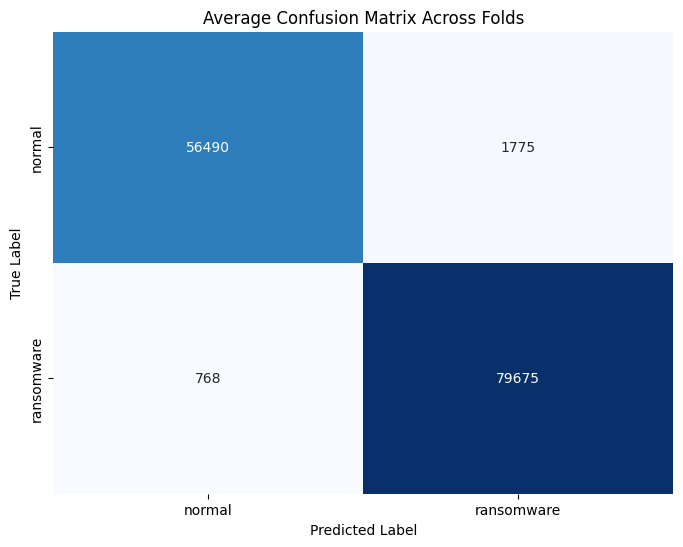


Classification Report for All Folds:
              precision    recall  f1-score   support

      normal       0.99      0.97      0.98     58265
  ransomware       0.98      0.99      0.98     80443

    accuracy                           0.98    138708
   macro avg       0.98      0.98      0.98    138708
weighted avg       0.98      0.98      0.98    138708



In [320]:
class_names = le.classes_

# Define TransformerModel class
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, nhead, d_model, dropout):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.dropout = nn.Dropout(dropout)
        self.output_layer = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        x = self.dropout(x)
        return self.output_layer(x)

# K-Fold dan Epoch
k_folds = 5
num_epochs = 10

# Hyperparameters
input_dim = X_train_tensor.shape[1]
num_classes = len(class_names)
nhead = 8
d_model = 128
dropout = 0.1
lr = 1e-3
batch_size = 32

model_dir = './Model/Best'
os.makedirs(model_dir, exist_ok=True)

output_dir = './Output'
os.makedirs(output_dir, exist_ok=True)

# K-Fold Cross-Validation
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Metrics collection
all_labels = []
all_preds = []
fold_results = []

print(f"Using best hyperparameters: nhead={nhead}, d_model={d_model}, "
      f"dropout={dropout}, lr={lr}, batch_size={batch_size}")

for fold, (train_index, val_index) in enumerate(kf.split(X_train_tensor)):
    print(f"Fold {fold + 1}/{k_folds}")

    # Data Loaders
    train_dataset = TensorDataset(X_train_tensor[train_index], y_train_tensor[train_index])
    val_dataset = TensorDataset(X_train_tensor[val_index], y_train_tensor[val_index])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    # Model, loss, and optimizer
    model = TransformerModel(input_dim=input_dim, num_classes=num_classes, nhead=nhead, d_model=d_model, dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    best_metrics = None

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        
        # Validation loop
        model.eval()
        total_val_loss = 0
        fold_labels, fold_preds = [], []

        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                val_outputs = model(X_val_batch)
                val_loss = criterion(val_outputs, y_val_batch)
                total_val_loss += val_loss.item()

                _, preds = torch.max(val_outputs, 1)
                fold_labels.extend(y_val_batch.cpu().numpy())
                fold_preds.extend(preds.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        accuracy = accuracy_score(fold_labels, fold_preds) * 100
        f1 = f1_score(fold_labels, fold_preds, average='weighted')

        print(f"Epoch {epoch + 1}/{num_epochs}: Training Loss: {avg_train_loss:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%, F1 Score: {f1:.4f}")

        # Save the best model for this fold
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_metrics = (avg_train_loss, avg_val_loss, accuracy, f1)
            model_path = os.path.join(model_dir, f"best_model_fold_{fold + 1}.pth")
            torch.save(model.state_dict(), model_path)
            print(f"Saved best model for fold {fold + 1} at epoch {epoch + 1}.")

    fold_results.append(best_metrics)
    all_labels.extend(fold_labels)
    all_preds.extend(fold_preds)


# Buat atau buka file teks untuk menyimpan hasil
with open(os.path.join(output_dir, 'kfold_results.txt'), 'w') as f:
    # Tulis header untuk hasil cross-validation
    f.write("K-Fold Cross-Validation Results:\n\n")
    
    print(f"\nK-Fold Cross-Validation Results:")
    # Loop melalui hasil setiap fold dan tulis ke file
    for i, result in enumerate(fold_results):
        line = (f"Fold {i + 1} - Training Loss: {result[0]:.4f}, Validation Loss: {result[1]:.4f}, "
                f"Accuracy: {result[2]:.2f}%, F1 Score: {result[3]:.4f}\n")
        
        # Print ke layar dan simpan ke file
        print(line.strip())
        f.write(line)

# Average Metrics across folds
avg_train_loss = np.mean([result[0] for result in fold_results])
avg_val_loss = np.mean([result[1] for result in fold_results])
avg_accuracy = np.mean([result[2] for result in fold_results])
avg_f1 = np.mean([result[3] for result in fold_results])

with open(os.path.join(output_dir, 'average_metrics.txt'), 'w') as f:
    f.write("Average Metrics Across Folds:\n")
    f.write(f"Average Training Loss: {avg_train_loss:.4f}\n")
    f.write(f"Average Validation Loss: {avg_val_loss:.4f}\n")
    f.write(f"Average Accuracy: {avg_accuracy:.2f}%\n")
    f.write(f"Average F1 Score: {avg_f1:.4f}\n")


print('-----------------------------------------------------------------------------------------')
print("\nAverage Metrics:")
print(f"Average Training Loss: {avg_train_loss:.4f}")
print(f"Average Validation Loss: {avg_val_loss:.4f}")
print(f"Average Accuracy: {avg_accuracy:.2f}%")
print(f"Average F1 Score: {avg_f1:.4f}")

# Confusion Matrix
average_conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(average_conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Average Confusion Matrix Across Folds')
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
plt.show()

# Classification Report
print("\nClassification Report for All Folds:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Classification Report dan Simpan sebagai file teks
class_report = classification_report(all_labels, all_preds, target_names=class_names)
with open(os.path.join(output_dir, 'classification_report.txt'), 'w') as f:
    f.write("Classification Report Across All Folds:\n\n")
    f.write(class_report)

Hasil K-Fold Cross-Validation menunjukkan kinerja model yang sangat baik dalam mendeteksi ransomware. Rata-rata training loss adalah 0.0513, sementara validation loss mencapai 0.0385. Model mencatat rata-rata akurasi sebesar 98.56% dan average F1 Score 0.9856. 

Setiap fold menunjukkan hasil yang konsisten, dengan akurasi tertinggi 98.70% pada Fold 2 dan terendah 98.41% pada Fold 3.

# **Visualisasi**

### **Grafik K-Fold Cross-Validation Results and Average**

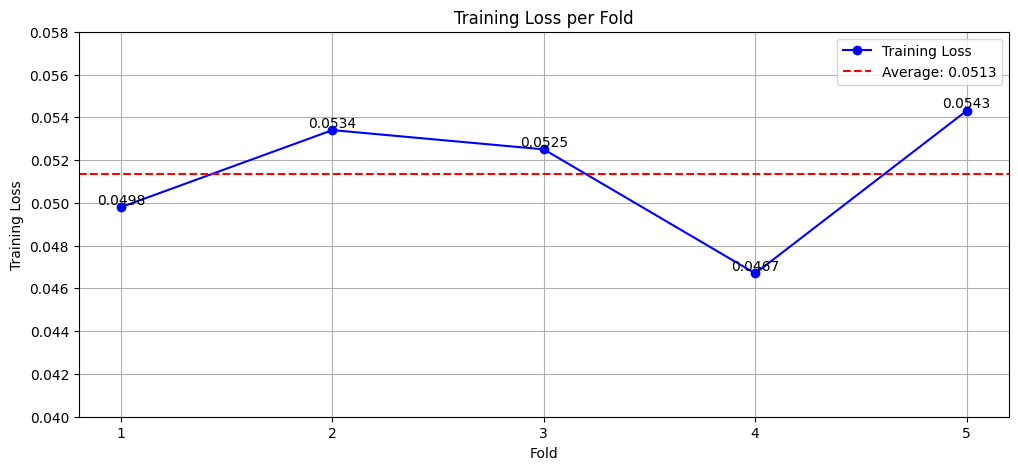

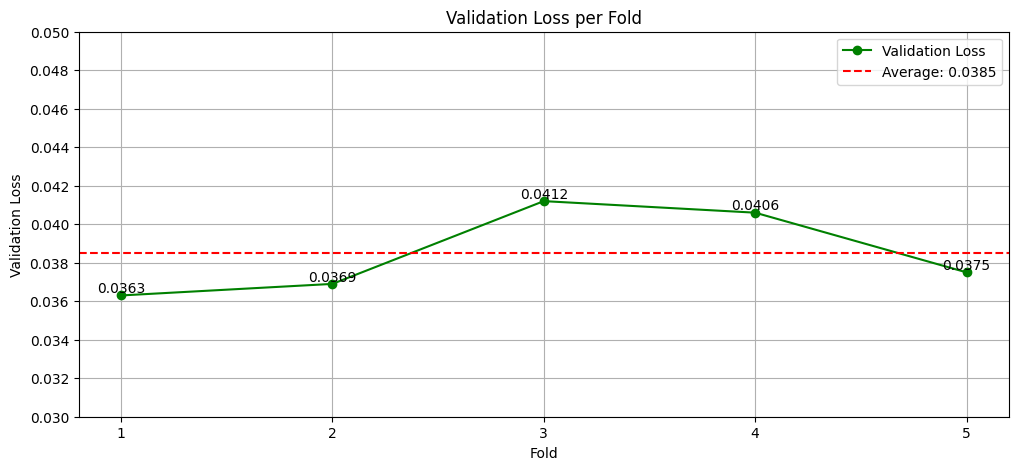

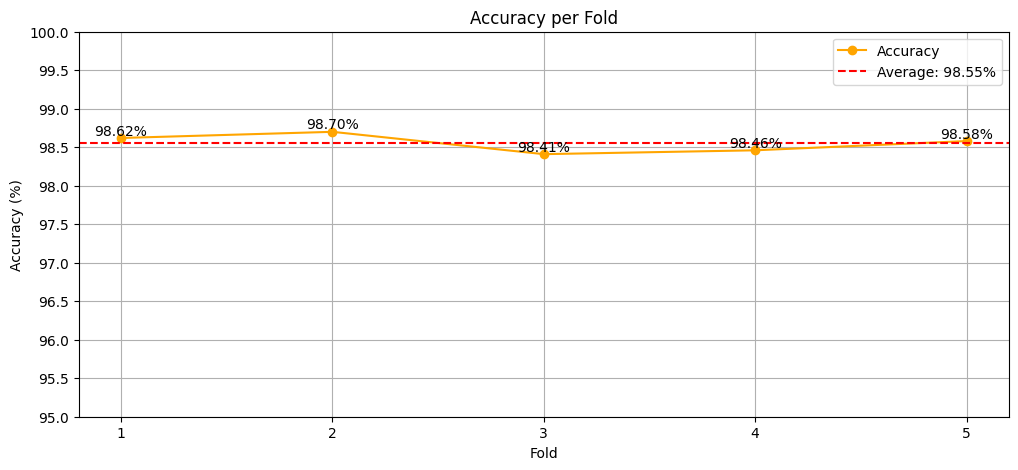

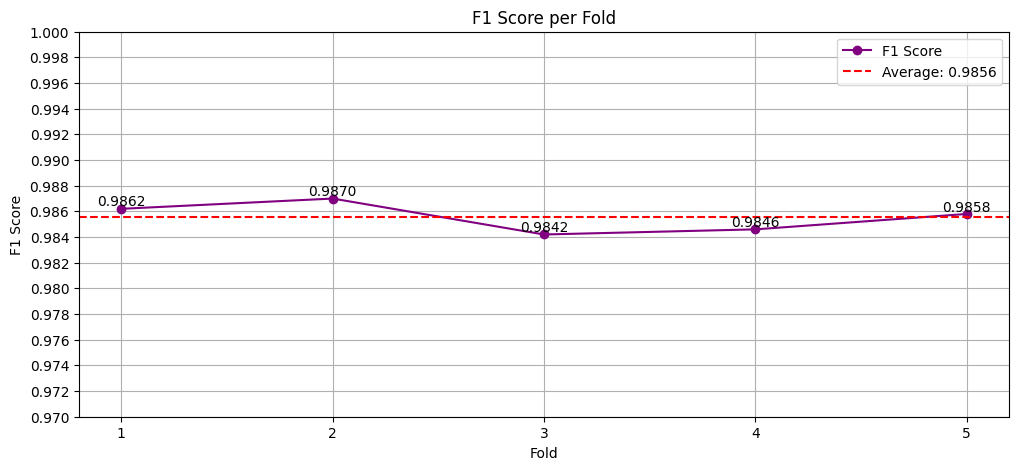

In [321]:
# Data K-Fold Cross-Validation Results
folds = 5
training_loss = [0.0498, 0.0534, 0.0525, 0.0467, 0.0543]
validation_loss = [0.0363, 0.0369, 0.0412, 0.0406, 0.0375]
accuracy = [98.62, 98.70, 98.41, 98.46, 98.58]
f1_score = [0.9862, 0.9870, 0.9842, 0.9846, 0.9858]

# Hitung rata-rata
average_training_loss = np.mean(training_loss)
average_validation_loss = np.mean(validation_loss)
average_accuracy = np.mean(accuracy)
average_f1_score = np.mean(f1_score)

# Membuat grafik Training Loss
plt.figure(figsize=(12, 5))
plt.plot(range(1, folds + 1), training_loss, marker='o', color='blue', label='Training Loss')
plt.axhline(y=average_training_loss, color='red', linestyle='--', label=f'Average: {average_training_loss:.4f}')
for i, loss in enumerate(training_loss):
    plt.text(i + 1, loss, f'{loss:.4f}', ha='center', va='bottom')
plt.title('Training Loss per Fold')
plt.xlabel('Fold')
plt.ylabel('Training Loss')
plt.xticks(range(1, folds + 1))
plt.yticks(np.arange(0.04, 0.06, 0.002))
plt.legend()
plt.grid(True)
plt.savefig('./Visualisasi/training_loss.png') 
plt.show()

# Membuat grafik Validation Loss
plt.figure(figsize=(12, 5))
plt.plot(range(1, folds + 1), validation_loss, marker='o', color='green', label='Validation Loss')
plt.axhline(y=average_validation_loss, color='red', linestyle='--', label=f'Average: {average_validation_loss:.4f}')
for i, loss in enumerate(validation_loss):
    plt.text(i + 1, loss, f'{loss:.4f}', ha='center', va='bottom')
plt.title('Validation Loss per Fold')
plt.xlabel('Fold')
plt.ylabel('Validation Loss')
plt.xticks(range(1, folds + 1))
plt.yticks(np.arange(0.03, 0.05, 0.002))
plt.legend()
plt.grid(True)
plt.savefig('./Visualisasi/validation_loss.png') 
plt.show()

# Membuat grafik Accuracy
plt.figure(figsize=(12, 5))
plt.plot(range(1, folds + 1), accuracy, marker='o', color='orange', label='Accuracy')
plt.axhline(y=average_accuracy, color='red', linestyle='--', label=f'Average: {average_accuracy:.2f}%')
for i, acc in enumerate(accuracy):
    plt.text(i + 1, acc, f'{acc:.2f}%', ha='center', va='bottom')
plt.title('Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.xticks(range(1, folds + 1))
plt.yticks(np.arange(95.0, 100.5, 0.5))
plt.legend()
plt.grid(True)
plt.savefig('./Visualisasi/accuracy.png') 
plt.show()

# Membuat grafik F1 Score
plt.figure(figsize=(12, 5))
plt.plot(range(1, folds + 1), f1_score, marker='o', color='purple', label='F1 Score')
plt.axhline(y=average_f1_score, color='red', linestyle='--', label=f'Average: {average_f1_score:.4f}')
for i, f1 in enumerate(f1_score):
    plt.text(i + 1, f1, f'{f1:.4f}', ha='center', va='bottom')
plt.title('F1 Score per Fold')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.xticks(range(1, folds + 1))
plt.yticks(np.arange(0.970, 1.0, 0.002))
plt.legend()
plt.grid(True)
plt.savefig('./Visualisasi/f1-score.png') 
plt.show()
